# PREDICTING EARNING POTENTIAL USING ADULT DATASET


#### The dataset used in this project has 48,842 records and a binomial label indicating a salary of <50K or >50K USD. 
Applying classification models to the problem of identifying individuals whose salary exceeds a specified value based on demographic information such as age, level of education and current employment type. The problem which I'm trying to solve using this data set is to be able to predict if a person falls in the income category below 50 thousand dollars or above 50 thousand dollars. The advantage of the trained model is it will support a business objective which will use the predictive capabilities of the proposed models to target customers to indicate the likely level of return on investment and overall profitability.
In this dataset 76% of the records have a class label of <50K. The data has been divided into a training set containing 32,561 records and a test dataset containing 16,281 records.
There are 14 attributes consisting of eight categorical and six continuous attributes. 
##### 1. Categorical Attributes 
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- education:  Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship:  Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race:  White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

##### 2. Continuous Attributes
- Age: age of an individual
- education-num: number of education year.
- fnlwgt: final weight, The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US.  These are prepared monthly for us by Population Division here at the Census Bureau.  
- capital-gain: continuous.
- captial-loss: continuous.
- hours-per-week: Individual's working hour per week.


Here's the reference for the dataset: [adult dataset](https://archive.ics.uci.edu/ml/datasets/Adult)

Alright let's get to building!!!

### SETUP AND LOAD DATA

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import model_selection, preprocessing, metrics
from sklearn.decomposition import PCA


## Understanding the dataset

In [3]:
data2=pd.read_csv("adult.csv",names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','target'])
data2.head(5) # returns five columns from dataset as shown below

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### The below table contains the descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

![alt text](Screenshot1.png)



In [34]:
lables = ['male earning less than 50k','male earning more than 50k','female earning less than 50k','female earning mpore thamn 50k']


 <=50K    24720
 >50K      7841
Name: target, dtype: int64


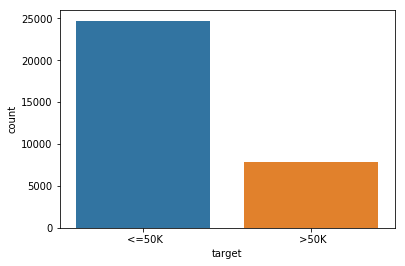

In [4]:
#Count the values of target variables
print(data2.target.value_counts())
sns.countplot(x='target', data=data2)
plt.show()




Income level less than 50K is more than 3 times of those above 50K, indicating that the the dataset is somewhat skewed. However, since there is no data on the upper limit of adult's income above 50K, it's premature to conclude that the total amount of wealth are skewed towards high income group.


### Co-relation of attributes in the dataset to target using Co-relation-HeatMap is shown below


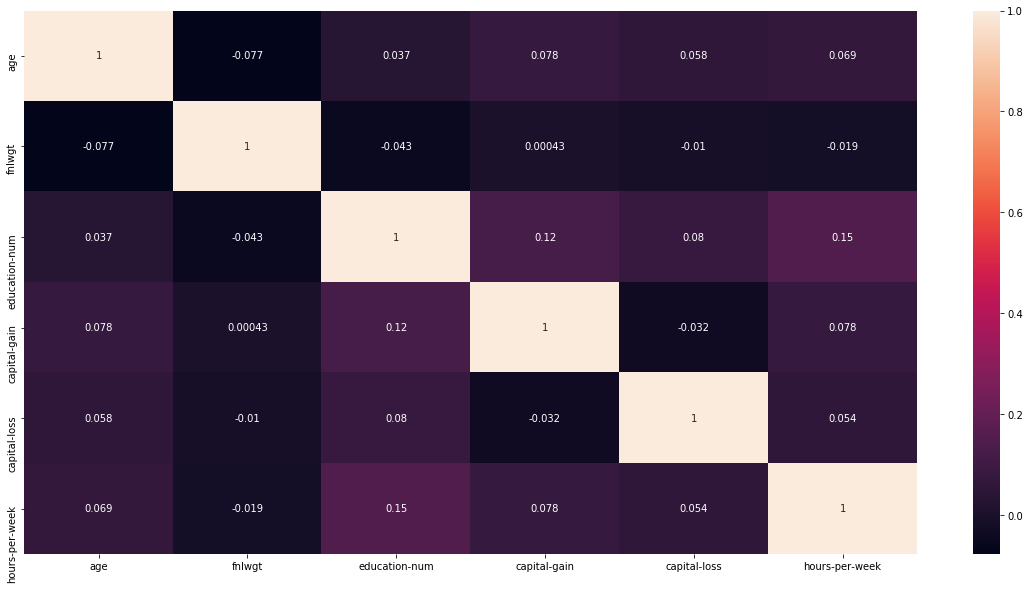

In [5]:
#Correlation between attributes
corr = data2.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True)
plt.show()
# co relation is shown only for numerical data in dataset

## Preprocessing of the dataset

1) Here looking at the dataset we can see that '?' exists denoting the missing values. We need to replace them with *NaN *using numpy's simple approach and replace them with the most occuring values or even the median of that column.We do not delete such row entries because it will reduce our dataset by a factor of 0.2

In [6]:
col_names = data2.columns
for c in col_names:
	data2[c] = data2[c].replace("?", np.NaN)

data2 = data2.apply(lambda x:x.fillna(x.value_counts().index[0]))

2)Now, we need to convert the categorical values to numeric for our Neural Network to train. Looking at the Marital-status col, there are nearly 6 different values which would mean the same as two values of being married ot no married, therefore we convert them into only two values.


3) Now we use labelEncoder to convert the categorical data into index values of an array of its inputs i.e. converting each value into a number. This is only done on attributes: ['race','marital-status', 'gender', 'income'] which do not contain more than 2 values.

#### NOTE : we do not want to fit our neural network into a model which contains a biased values for equivalent attribute values. To avoid this, we use Dummy variables method.

4) Here we implement get_dummies method of pandas library to create new colums for our data where each attribute value's occurance in any input instance is denoted by either 0 or 1.


In [7]:
labelEncoder = preprocessing.LabelEncoder()
category_col =['race','marital-status', 'sex', 'target'] 

for col in category_col:
    data2[col] = labelEncoder.fit_transform(data2[col])

category_col_1 =['workclass', 'education', 'occupation',
               'relationship','native-country'] 
data = pd.get_dummies(data2, columns=category_col_1, drop_first=True)

##unknown Attribute is removed and income class label is appended in the end
dataframe=data.drop('fnlwgt',1)
final_data =dataframe[[c for c in dataframe if c not in ['target']] + ['target']]


#### Final data is shown below

In [8]:
final_data.head(10)

,age,education-num,marital-status,race,sex,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,target
0,39,13,4,4,1,2174,0,40,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,13,2,4,1,0,0,13,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,9,0,4,1,0,0,40,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,7,2,2,1,0,0,40,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,13,2,2,0,0,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0
5,37,14,2,4,0,0,0,40,0,0,...,0,0,0,0,0,0,1,0,0,0
6,49,5,3,2,0,0,0,16,0,0,...,0,0,0,0,0,0,0,0,0,0
7,52,9,2,4,1,0,0,45,0,0,...,0,0,0,0,0,0,1,0,0,1
8,31,14,4,4,0,14084,0,50,0,0,...,0,0,0,0,0,0,1,0,0,1
9,42,13,2,4,1,5178,0,40,0,0,...,0,0,0,0,0,0,1,0,0,1


In [9]:
X = final_data.iloc[:, 0:91].values
Y = final_data.iloc[:, 91].values


##### Principal Component Analysis (PCA)
Is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set. Since our dataset has  92 columns it has to be reduced to 11 columns by running the code 

In [10]:
pca = PCA(n_components=11)
x = pca.fit_transform(X)
x.shape

(32561, 11)


## Training the Neural Network

1) Now we train and test the data on the model using cross validation method. Training is done on 18233 samples and is validated with 4559 samples.

2) I have used a simple model of a neural network where there is one input layer, one output layer and one hidden layer. The first two use tanh activation function but the Output layer uses softmax activation function to ensure our network output is between 0 and 1. We run the training model for 20 epochs.



In [11]:
model = tf.keras.Sequential([
    keras.layers.Dense(25, input_shape=(X[0].shape), activation=tf.nn.tanh),
    keras.layers.Dense(13, activation=tf.nn.tanh),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.3)


AdamOptimizer: Adaptive Moment Estimation (Adam) keeps separate learning rates for each weight as well as an exponentially decaying average of previous gradients. This combines elements of Momentum and Adagrad together and is fairly memory efficient since it doesn’t keep a history of anything (just the rolling averages). It is reputed to work well for both sparse matrices and noisy data. Adam seems promising for the stock market data.

Read more about AdamOptimizer from tensorflow documentation :[AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

In [18]:
model.compile(loss='sparse_categorical_crossentropy',
            optimizer=keras.optimizers.Adam(0.0001),
             metrics=['accuracy'])

We have divided our entire dataset into 20 batches and fed into our model(Artifical Neural Network) with validation split as 20% of the data. Verbose sets the threshold for what messages will be logged.

##### Lets run our model now!!

In [23]:
history = model.fit(xtrain, ytrain, epochs=10, validation_split=0.2, verbose=2)

Train on 18233 samples, validate on 4559 samples
Epoch 1/10
 - 1s - loss: 0.3209 - acc: 0.8533 - val_loss: 0.3141 - val_acc: 0.8555
Epoch 2/10
 - 1s - loss: 0.3197 - acc: 0.8522 - val_loss: 0.3140 - val_acc: 0.8557
Epoch 3/10
 - 1s - loss: 0.3197 - acc: 0.8526 - val_loss: 0.3143 - val_acc: 0.8555
Epoch 4/10
 - 1s - loss: 0.3182 - acc: 0.8548 - val_loss: 0.3123 - val_acc: 0.8561
Epoch 5/10
 - 1s - loss: 0.3181 - acc: 0.8543 - val_loss: 0.3114 - val_acc: 0.8570
Epoch 6/10
 - 1s - loss: 0.3187 - acc: 0.8541 - val_loss: 0.3121 - val_acc: 0.8541
Epoch 7/10
 - 1s - loss: 0.3176 - acc: 0.8547 - val_loss: 0.3125 - val_acc: 0.8557
Epoch 8/10
 - 1s - loss: 0.3182 - acc: 0.8542 - val_loss: 0.3149 - val_acc: 0.8572
Epoch 9/10
 - 1s - loss: 0.3176 - acc: 0.8554 - val_loss: 0.3112 - val_acc: 0.8576
Epoch 10/10
 - 1s - loss: 0.3165 - acc: 0.8550 - val_loss: 0.3124 - val_acc: 0.8546


#### Now we plot the results and visualize the performance of the Neural Network by plotting loss vs epochs(iters) curve
- The curve with red colour represents the loss incured for validation vs epochs
- The curve with green colour represents the training loss vs epochs

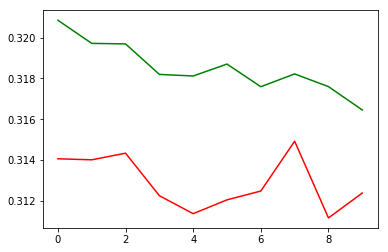

In [24]:
plt.plot(history.epoch, history.history['loss'], 'g')
plt.plot(history.epoch, history.history['val_loss'],'r')

## Insights from the above trained model

After training our model the accuracy was found to be approximately 82 percent.
The final accuracy tells that given a new data about an adult, it will predict correctly 84% of the time whether a person falls in the income category below 50 thousand dollars or above 50 thousand dollars.

In [35]:
loss, accuracy = model.evaluate(xtest,ytest)

9769/9769 [==============================] - 0s 31us/step


In [36]:
print("Accuracy: ", accuracy)

Accuracy:  0.8497287337496161
